Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


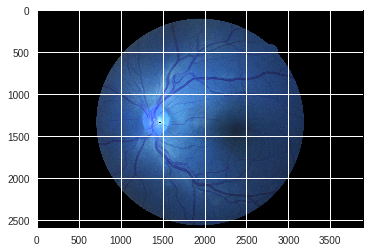

In [0]:
from PIL import Image
import PIL.ImageOps    
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave
import cv2
import os

from google.colab import drive
drive.mount('/content/gdrive')
input_path = "/content/gdrive/My Drive/Colab Notebooks/"
            
path = os.path.join(input_path, "train")

for file in os.listdir(path):
    current = os.path.join(path, file)
    extension = os.path.splitext(current)[-1]
  
    
    if extension == ".jpeg":

            train_files = glob.glob(os.path.join(input_path, "train", "*.jpeg"))
            img_file = current

            img = cv2.imread(img_file)
            out_path = '/content/gdrive/My Drive/Colab Notebooks/img/' + file


            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            ret, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

            img[thresh == 255] = 0

            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            erosion = cv2.erode(img, kernel, iterations = 1)

            cv2.imwrite(out_path, erosion)


          #cv2.namedWindow('image', cv2.WINDOW_NORMAL)
          #cv2.imshow("image", erosion)
          #cv2.waitKey(0)
          #cv2.destroyAllWindows()
            plt.imshow(img)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


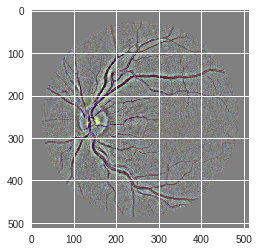

In [0]:
import cv2, glob, os
import numpy as np
import pandas as pd  
%matplotlib inline
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

input_path = "/content/gdrive/My Drive/Colab Notebooks/"
path = os.path.join(input_path, "train")

def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2

    return (ry, rx)
  
def crop_img(img, h, w):
    h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
    w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

    crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]

    return crop_img
  
def subtract_gaussian_blur(img):
    gb_img = cv2.GaussianBlur(img, (0, 0), 5)    
    return cv2.addWeighted(img, 4, gb_img, -4, 128)
        


def remove_outer_circle(a, p, r):
    b = np.zeros(a.shape, dtype=np.uint8)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)    
    return a * b + 128 * (1 - b)




def place_in_square(img, r, h, w):
    new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
    new_img += 128
    new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
    
    return new_img

for file in os.listdir(path):
    current = os.path.join(path, file)
    extension = os.path.splitext(current)[-1]
    
   
    
    if extension == ".jpeg":


        train_files = glob.glob(os.path.join(input_path, "train", "*.jpeg"))

        scale = 256 # target radius

        img_file = current

        img = cv2.imread(img_file)




        ry, rx = estimate_radius(img)

        resize_scale = scale / max(rx, ry)
        w = min(int(rx * resize_scale * 2), scale * 2)
        h = min(int(ry * resize_scale * 2), scale * 2)
        img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)





        img_crop = crop_img(img_resize.copy(), h, w)
        img_gbs = subtract_gaussian_blur(img_crop.copy())
        img_remove_outer = remove_outer_circle(img_gbs.copy(), 0.9, scale)
        new_img = place_in_square(img_remove_outer.copy(), scale, h, w)
        cv2.imwrite("/content/gdrive/My Drive/Colab Notebooks/img_save/" + file, new_img)
        plt.imshow(new_img)





In [0]:
import os
import sys
from PIL import Image
import math

def fileSize(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

def compressMe(file, num = 0):
	blackColorStart = '\033[90m'
	blackColorEnd = '\033[0m'
	sourcePath = "/content/gdrive/My Drive/Colab Notebooks/train"
	targetPath = "/content/gdrive/My Drive/Colab Notebooks/train"
	filepath = os.path.join(sourcePath, file)
	oldsize = os.stat(filepath).st_size
	picture = Image.open(filepath)
	dim = picture.size

	picture.save(targetPath+file,"JPEG",optimize=True,quality=65) 
	
	newsize = os.stat(os.path.join(targetPath,file)).st_size
	percent = (oldsize-newsize)/float(oldsize)*100

	return percent

def main():
	imagePath = "/content/gdrive/My Drive/Colab Notebooks/train"

	tot = 0
	num = 0
	for file in os.listdir(imagePath):
		if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg', '.gif', '.png'):
			num += 1
			tot += compressMe(file, num)


if __name__ == "__main__":
	main()

In [0]:
import numpy as np
import cv2, os
import sys
import pandas as pd
import tensorflow as tf

from google.colab import drive
drive.mount('/content/gdrive')
 
normalization_offset = 0.0  # beta
normalization_scale = 1.0  # gamma
normalization_epsilon = 0.001  # epsilon


class Tensorflow_Model():
    __W = None
    __b = None

    def __init__(self, image_dims, output_dims):
        self.dims_image = image_dims
        self.dims_output = output_dims
        self.padding = 'SAME'
        self.sess = tf.Session()

        self.__W = {
            1: tf.Variable(tf.truncated_normal([5, 5, 3, 64], stddev=0.1)),
            2: tf.Variable(tf.truncated_normal([5, 5, 64, 128], stddev=0.1)),
            3: tf.Variable(tf.truncated_normal([5, 5, 128, 256], stddev=0.1)),
            4: tf.Variable(tf.truncated_normal([5, 5, 256, 1024], stddev=0.1)),
            5: tf.Variable(tf.truncated_normal([1048576, output_dims], stddev=0.1)),
        }
     
        self.__b = {
            1: tf.Variable(tf.random_normal([64])),
            2: tf.Variable(tf.random_normal([128])),
            3: tf.Variable(tf.random_normal([256])),
            4: tf.Variable(tf.random_normal([1024])),
            5: tf.Variable(tf.random_normal([output_dims])),
        }

    def normalize(self,x):
        """ Applies batch normalization """
        mean, variance = tf.nn.moments(x, [1, 2, 3], keep_dims=True)
        return tf.nn.batch_normalization(x, mean, variance, normalization_offset, normalization_scale, normalization_epsilon)

    def model(self, inp):
       
        
        # Layer 1
        input = self.normalize(inp)
        #input = inp
        layer1_conv1 = tf.nn.conv2d(input, self.__W[1], strides=[1, 1, 1, 1], padding=self.padding)
        layer1_relu1 = tf.nn.relu(tf.nn.bias_add(layer1_conv1, self.__b[1]))
        layer1_max_pool1 = tf.nn.max_pool(layer1_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=self.padding)

        # Layer 2
        layer2_conv1 = tf.nn.conv2d(layer1_max_pool1, self.__W[2], strides=[1, 1, 1, 1], padding=self.padding)
        layer2_relu1 = tf.nn.relu(tf.nn.bias_add(layer2_conv1, self.__b[2]))
        layer2_max_pool1 = tf.nn.max_pool(layer2_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=self.padding)

        # Layer 3
        layer3_conv1 = tf.nn.conv2d(layer2_max_pool1, self.__W[3], strides=[1, 1, 1, 1], padding=self.padding)
        layer3_relu1 = tf.nn.relu(tf.nn.bias_add(layer3_conv1, self.__b[3]))
        layer3_max_pool1 = tf.nn.max_pool(layer3_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=self.padding)

        # Layer 4
        layer4_conv1 = tf.nn.conv2d(layer3_max_pool1, self.__W[4], strides=[1, 1, 1, 1], padding=self.padding)
        layer4_relu1 = tf.nn.relu(tf.nn.bias_add(layer4_conv1, self.__b[4]))
        layer4_max_pool1 = tf.nn.max_pool(layer4_relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=self.padding)
        w4 = (layer4_max_pool1.get_shape()[1:]).as_list()
        #        self.__W[4] = tf.Variable(tf.truncated_normal([tf.reduce_prod(self.w4), 1024], stddev=0.1))
        #        print(self.w4)

        # Flatten
        flatten = tf.reshape(layer4_max_pool1, [-1, tf.reduce_prod(w4)])
        print('flatten shape: {}'.format(flatten.shape))

        # Fully Connected Network
        fc1 = tf.nn.relu(tf.matmul(flatten, self.__W[5]) + self.__b[5])

        # out = tf.nn.relu(tf.matmul(fc1, self.__W[5]) + self.__b[5])

        out = tf.layers.dense(inputs=fc1, units=5)
        dropout = tf.layers.dropout(inputs=out, rate=0.6)  # , training=tf.estimator.ModeKeys.TRAIN)

        # out = tf.nn.relu(tf.matmul(dense, self.__W[5]) + self.__b[5])
        #        print(out.get_shape().as_list())

        return dropout

    def one_hot(self, Y):
        max = np.max(Y)
        one_hot_encoded = np.zeros([Y.shape[0], max + 1])
        for i, y in enumerate(Y):
            one_hot_encoded[i, y] = 1
        return one_hot_encoded


    def get_x_y(self, data):
        # print('Data shape: {}'.format(data.shape))
        # print('Y values: {}'.format(data[:, 1]))
        x = np.array([x for x in data[:, 0]]).reshape(
            [-1, self.dims_image['height'], self.dims_image['width'], self.dims_image['channel']])
        y = self.one_hot(data[:, 1])
        print('x shape: {}'.format(x.shape))
        print('y shape: {}'.format(y.shape))

        return x, y

    def train(self, data):
        avg_cost = 0
        with tf.device('/gpu:0'):
            x = tf.placeholder(tf.float32,
                               [None, self.dims_image['height'], self.dims_image['width'], self.dims_image['channel']])
            y = tf.placeholder(tf.float32, [None, self.dims_output])
            _y = self.model(x)
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=_y, labels=y))
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
            corr = tf.equal(tf.argmax(_y, 1), tf.argmax(y, 1))
            accr = tf.reduce_mean(tf.cast(corr, tf.float32))
           
            kavya = tf.nn.softmax_cross_entropy_with_logits(logits=_y, labels=y)
            batch_x, batch_y = self.get_x_y(data)
            print("Kavya : \n", batch_y)
            self.sess.run(tf.initialize_all_variables())
            self.sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            avg_cost += self.sess.run(cost, feed_dict={x: batch_x, y: batch_y}) / self.dims_output
            train_acc = self.sess.run(accr, feed_dict={x: batch_x, y: batch_y})
            print('Average Cost: {}, Training Accuracy: {}'.format(avg_cost, train_acc))

class dl_model():

    EXT_TRAIN_DATA = 'img_save'
    EXT_TEST_DATA = 'test'
    EXT_TRAIN_CSV = 'old_trainLabels.csv'
    
    IMAGE_WIDTH = 512 #1536
    IMAGE_HEIGHT = 512 #1024
    N_CHANNELS = 3
    
    GENERATOR_BATCH_SIZE = 100
    NB_EPOCH_PER_BATCH = 2
    NB_EPOCH = 1
    
    def __init__(self):
        #self.argv = argv
        self.BASE_PATH = "/content/gdrive/My Drive/Colab Notebooks"
        self.dims_image = {'width': self.IMAGE_WIDTH, 'height': self.IMAGE_HEIGHT, 'channel': self.N_CHANNELS}
        self.dims_output = 5
    
    def get_image_name_list(self, path, train_or_not):
        if train_or_not:
            training_csv = pd.read_csv(path)
            headers = training_csv.columns
            return np.array([training_csv[headers[0]], training_csv[headers[1]]])
        else:
            return np.array([os.listdir(path)])

    def get_image_names(self):
        self.train_image_names_with_labels = self.get_image_name_list(os.path.join(self.BASE_PATH, self.EXT_TRAIN_CSV), 1) # returns a tuple
        self.test_image_names = self.get_image_name_list(os.path.join(self.BASE_PATH, self.EXT_TEST_DATA), 0) # returns just names

        print('Number of training images: {}\nNumber of testing images: {}'.format(len(self.train_image_names_with_labels[0]), len(self.test_image_names[0])))

    def image_transformation(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
        return np.array(img).reshape((self.IMAGE_HEIGHT, self.IMAGE_WIDTH, self.N_CHANNELS))

    def image_batch_generator(self, array, batch_size, ext):
        path = os.path.join(self.BASE_PATH, ext)
        for i in range(0, len(array[0]), batch_size):
            batch = array[0][i: i+batch_size]
            data_batch = []
            for j, image_name in enumerate(batch):
                try:
                    if ext == self.EXT_TRAIN_DATA:
                        image_path = '{}.jpeg'.format(os.path.join(path, image_name))
                        data_batch.append((self.image_transformation(image_path), array[1][i+j]))
                    else:
                        image_path = '{}'.format(os.path.join(path, image_name))
                        data_batch.append(self.image_transformation(image_path))
                except:
                    print('Error reading: {}'.format(image_path))
            yield(np.array(data_batch))
    
    def execute(self):
        with tf.device('/gpu:0'):
            self.get_image_names()
            training_batch_generator = self.image_batch_generator(self.train_image_names_with_labels, self.GENERATOR_BATCH_SIZE, self.EXT_TRAIN_DATA)
            tf_model = Tensorflow_Model(self.dims_image, self.dims_output) # CALCULATE dims_output
            
            
            # TRAINING PHASE
            for i, training_batch in enumerate(training_batch_generator):
                if not i > self.NB_EPOCH:

                    tf_model.train(training_batch)

                else:
                    break



if __name__ == '__main__':
    dl_model().execute()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of training images: 14
Number of testing images: 13
flatten shape: (?, 1048576)
x shape: (14, 512, 512, 3)
y shape: (14, 5)
Kavya : 
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
Average Cost: 0.32176196575164795, Training Accuracy: 0.6428571343421936


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
